In [61]:
# REFERENCE: https://github.com/yahsiuhsieh/frozen-lake

import numpy as np
import pygame
import time
import matplotlib.pyplot as plt

# VALUE ITERATION ALGORITHM ###############################

class value_iterator:    
    def __init__(self, state_dim, action_dim):
        
        # game settings
        self.map_name = "8x8"
        self.is_slippery = True
        
        # internal states
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.value_function = np.zeros(state_dim)
        self.policy = np.zeros(state_dim, dtype=int)
        
        # hyperparams
        self.model_timesteps = 1e5
        self.value_iterations = 50
        self.test_iterations = 20
        self.max_test_timesteps = 25
        self.gamma = 0.99
        self.seed = 0
        
    """
    Learn the transition and reward function for the environment.
    """    
    def learn_model(self):
        
        # Collect transitions ---------------
        
        transition_function = np.zeros((self.state_dim, self.action_dim, self.state_dim))
        reward_function = np.zeros((self.state_dim, self.action_dim, self.state_dim))
        t = 0
        
        while t < self.model_timesteps:
            
            env = gym.make("FrozenLake-v1", map_name=self.map_name, is_slippery=self.is_slippery)
            env.seed(self.seed)
            
            # reset the state
            s, d = env.reset(), False
            while not d:
                
                # display progress
                if t % (self.model_timesteps // 10) == 0: print("M: Timestep {}".format(t))
                
                # take an action
                a = env.action_space.sample()
                n_s, r, d, _ = env.step(a)
                
                # update transition and reward function
                transition_function[n_s, a, s] += 1
                reward_function[n_s, a, s] += r
                
                # update the state
                s = n_s
                t += 1        
                
        # Normalise the transition function -------------- 
        
        for s_i in range(self.state_dim):
            for a_i in range(self.action_dim):  
                
                # norm the transitions to probabilities
                n_s_max = np.sum(transition_function[:, a_i, s_i])  
                transition_function /= max(n_s_max, 1)
                reward_function /= max(n_s_max, 1)   
                                
        # set as global states
        self.transition_function = transition_function
        self.reward_function = reward_function
        
        print('M: Training Complete')
        print('--------------------------\n')
    
    """
    Learn the value function using the learned reward and transition function.
    """
    def learn_value(self):
        
        success_tally = []
        for i in range(self.value_iterations):
            
            # display progress
            if i % (self.value_iterations // 10) == 0: print("V: Iteration {}".format(i))
            
            # Update the value function estimate ---------------------------
            
            for s_i in range(self.state_dim):
                temp_state_value = 0                
                for a_i in range(self.action_dim):
                    
                    # calculate the sum of reward for given action
                    temp_action_value = np.sum(self.transition_function[:, a_i, s_i] *  
                                               (self.reward_function[:, a_i, s_i] + self.gamma * self.value_function[:]))
                    temp_state_value = max(temp_state_value, temp_action_value)
                
                # update the value function
                self.value_function[s_i] = temp_state_value
                            
            # Use the value function to select the policy -----------------

            for s_i in range(self.state_dim):
                temp_state_value = 0                
                for a_i in range(self.action_dim):

                    # calculate the sum of reward for given action
                    temp_action_value = np.sum(self.transition_function[:, a_i, s_i] *  
                                               (self.reward_function[:, a_i, s_i] + self.gamma * self.value_function[:]))

                    # update the policy
                    if temp_action_value > temp_state_value:
                        self.policy[s_i] = a_i
                        temp_state_value = temp_action_value                            
                        
            # test iteration
            success_rate = self.test_policy(render=False)
            success_tally.append(success_rate)
                    
        print("V: Training Complete")
        print('--------------------------\n')
        
        plt.plot(list(range(len(success_tally))), success_tally)
        
    """
    Test the learned policy on the environment
    """                
    def test_policy(self, render=False, ep=None):
        
        itr = self.test_iterations
        if render: itr = 1
        
        counter = 0
        for i in range(itr):
            
            env = gym.make("FrozenLake-v1", map_name=self.map_name, is_slippery=self.is_slippery)
            s, d, t = env.reset(), False, 0            
            while t < self.max_test_timesteps:
                
                if render: 
                    env.render()
                    time.sleep(1)
                
                # take action
                a = self.policy[s]
                s_n, r, d, _ = env.step(a)
                
                # update state
                t += 1
                s = s_n
                
                if d:
                    counter += 1
                    break
                    
        if render: pygame.quit()
        
        if ep is not None:
            if ep % (self.value_iterations // 10) == 0: 
                print("Success rate: {}%".format(round(counter / self.test_iterations * 100, 2)))    
        
        return counter / self.test_iterations * 100

M: Timestep 0
M: Timestep 10000
M: Timestep 20000
M: Timestep 30000
M: Timestep 40000
M: Timestep 50000
M: Timestep 60000
M: Timestep 70000
M: Timestep 80000
M: Timestep 90000
M: Timestep 100000
M: Training Complete
--------------------------

V: Iteration 0
V: Iteration 5
V: Iteration 10
V: Iteration 15
V: Iteration 20
V: Iteration 25
V: Iteration 30
V: Iteration 35
V: Iteration 40
V: Iteration 45
V: Training Complete
--------------------------



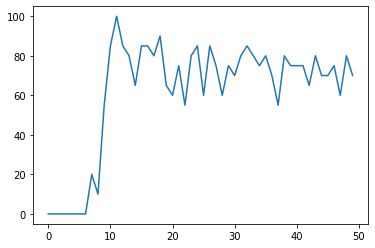

In [62]:
import gym

# TRAINING ################################################

agent = value_iterator(
    state_dim = env.observation_space.n,
    action_dim = env.action_space.n,
)

agent.learn_model()
agent.learn_value()